## Biodiversity of Endangered Species in National Parks

#### Introduction:
Data on biodiversity of endangered species in National Parks has been provided by Codecademy as part of a portfolio project prompt.

The brief on the project states that the data is from the National Parks Service and covers observations of different species of various conservation levels at several US National parks. It states that we will investigate to find any patterns or themes to the types of species that become endangered. During this project I have transformed and loaded the data, investigated patterns and themes, and created representative visuals.

The initial dataset included two csv's, 'observations.csv' and 'species_info.csv'. Observations.csv contains 23296 rows of data on the species observed within four National Parks, with a count of observations, park where it was observed and scientific name of the species. The species_info.csv contains columns for scientific name, common names, and conservation status and has data for 5824 species. In data_cleaning_biodiversity.ipynb I removed duplicates, resolved missing data, and merged the two csv into one, biodiversity_data.csv for analysis.

The dataset includes scientific_name, common_names, the observation count, and three categorical variables. The categorical variables:
| Column Name | N-Unique | Unique Values |
| --- | ----------- | --------- |
| park_name | 4 | 'Bryce', 'Great Smokey Mountain', 'Yellowstone', 'Yosemite' | 
| conservation_status | 5 | 'Least Concern', 'Species of Concern', 'Threatened', 'Endangered', 'In Recovery' |
| category | 7 | 'Vascular Plant', 'Nonvascular Plant', 'Amphibian', 'Bird', 'Fish', 'Reptile', 'Mammal' |

Observations has the following spread:



- Describe the data set and prior cleaning, including modes/averages/histograms, counts of species within categories,
- Describe analysis and conclusions. 
- Focus on most interesting conclusion/finding

In [179]:
#import py libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
#set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})

In [180]:
biodiv = pd.read_csv("biodiversity_data.csv")
print(biodiv.describe())

       observations
count       22164.0
mean          149.5
std            81.2
min             9.0
25%            88.0
50%           129.0
75%           217.0
max           805.0


- Identifiers: scientific name, common names
- Categorical variables: park_name, category, conservation status
- Quatitative variables: observations


Since all species apart from those in the 'Least concern' conservation status are in a protected group, we can create a new column protection_listing that is binomial for the 'conservation_status' variable where 0 is 'Least Concern', and all other values are 1, ('Species of Concern', 'Threatened', 'Endangered', 'In Recovery')

In [181]:
#the protection listing of a species can be thought of as an binomial variable where species of Least Concern: 0 and protection listed classes: 1. 
protected_class = {'Least Concern': 0, 'Species of Concern': 1, 'In Recovery': 1, 'Threatened':1, 'Endangered':1}
biodiv['protection_listing'] = biodiv['conservation_status'].apply(lambda x: protected_class.get(x))
print(biodiv.describe(include= 'all'))

       scientific_name park_name  observations        category conservation_status        common_names  protection_listing
count            22164     22164       22164.0           22164               22164               22164             22164.0
unique            5541         4           NaN               7                   5                5236                 NaN
top      Abies bifolia     Bryce           NaN  Vascular Plant       Least Concern  Brachythecium Moss                 NaN
freq                 4      5541           NaN           17048               21448                  28                 NaN
mean               NaN       NaN         149.5             NaN                 NaN                 NaN                 0.0
std                NaN       NaN          81.2             NaN                 NaN                 NaN                 0.2
min                NaN       NaN           9.0             NaN                 NaN                 NaN                 0.0
25%             

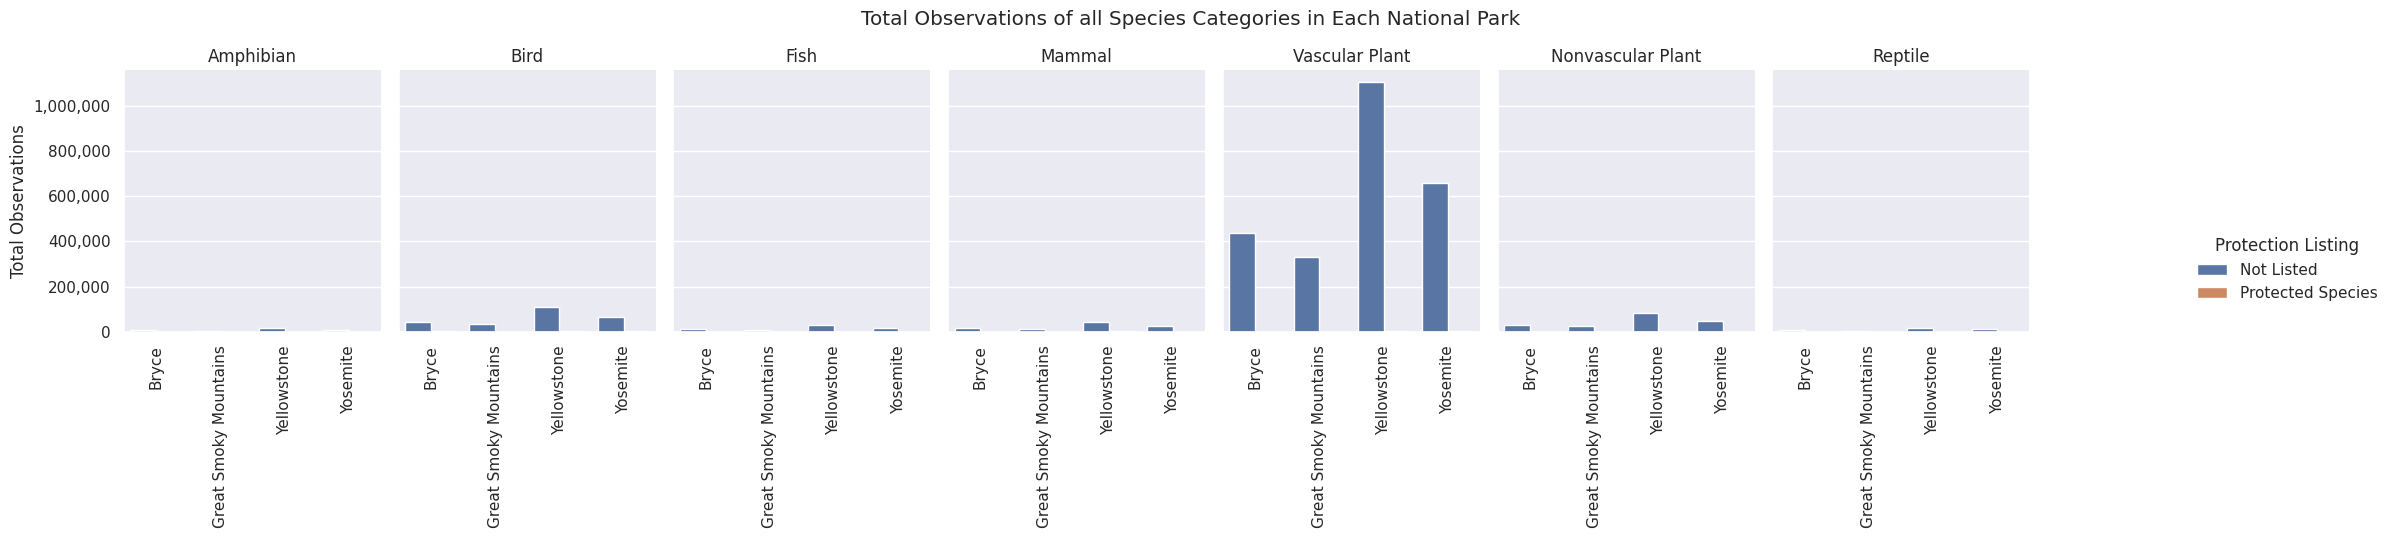

In [182]:
# create a visual of the data spread
biodiv_grouped = biodiv.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()

a=sns.catplot(
    data = biodiv_grouped,
    x='park_name',
    y='observations',
    col = 'category',
    hue= 'protection_listing',
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
    #sharey= 'none'
    legend_out= True
)
a.set_xticklabels(rotation = 90)
a.set_titles("{col_name}")
a.figure.subplots_adjust(top=.86)
a.figure.suptitle('Total Observations of all Species Categories in Each National Park')
a.set_axis_labels('', 'Total Observations')
for ax in a.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
legend = a._legend
legend.set_title('Protection Listing')
for t, l in zip(legend.texts,('Not Listed', 'Protected Species')):
    t.set_text(l)
a.fig.subplots_adjust(top=0.83
                      ,right=0.85)
#Plants and Species of Least Concern are hiding the visibility of vulnerable species. 


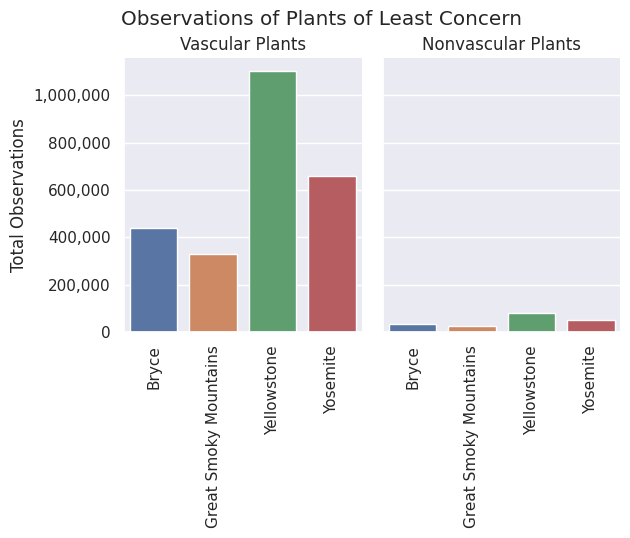

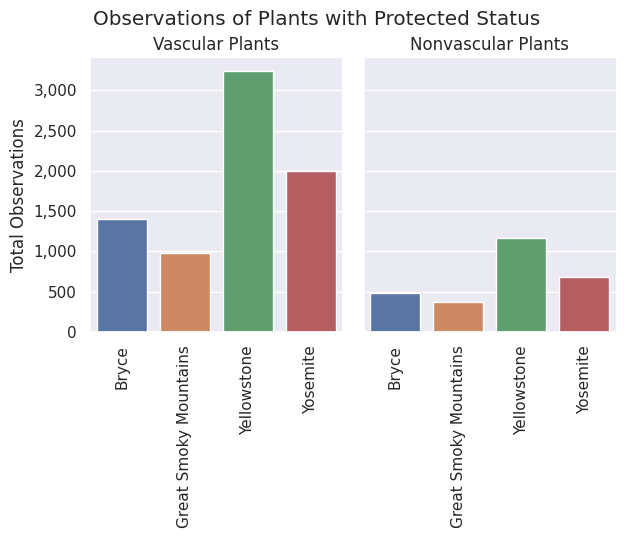

In [183]:
#For greater visibility into the protection status of relative groups of species and plants we can split into two dataframes, one for plants and one for animals.
#plants
biodiv_plants = biodiv[biodiv['category'].str.contains('Plant')].reset_index(drop=True)
biodiv_plants_gp_status= biodiv_plants.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()

g=sns.catplot(
    data = biodiv_plants_gp_status[biodiv_plants_gp_status['protection_listing']==0],
    x='park_name',
    y='observations',
    col = 'category',
    col_order = ['Vascular Plant', 'Nonvascular Plant'],
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
    #sharey= 'none'
)
g.set_xticklabels(rotation = 90)
g.set_titles("{col_name}s")
g.figure.subplots_adjust(top=.86)
g.figure.suptitle('Observations of Plants of Least Concern')
g.set_axis_labels('', 'Total Observations')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

h=sns.catplot(
    data = biodiv_plants_gp_status[biodiv_plants_gp_status['protection_listing']==1],
    x='park_name',
    y='observations',
    col = 'category',
    col_order = ['Vascular Plant', 'Nonvascular Plant'],
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = 0.8,
)
h.set_xticklabels(rotation = 90)
h.set_titles("{col_name}s")
h.figure.subplots_adjust(top=.86)
h.figure.suptitle('Observations of Plants with Protected Status')
h.set_axis_labels('', 'Total Observations')
for ax in h.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()
plt.close("all")

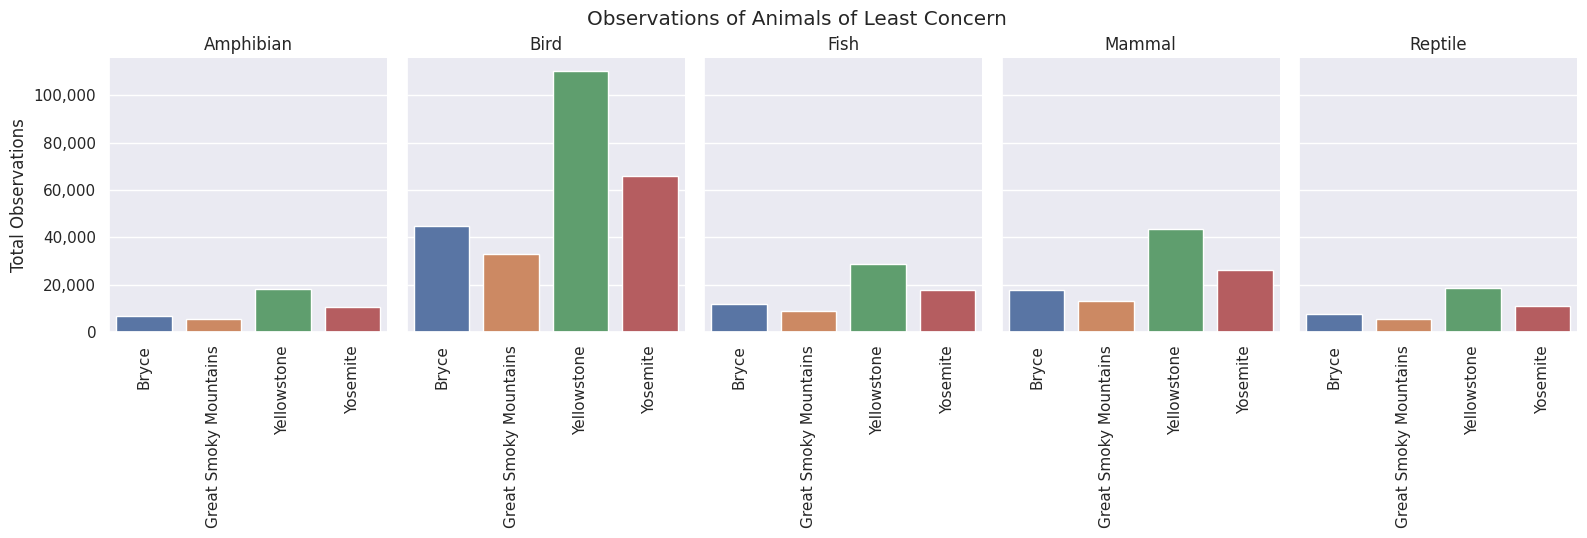

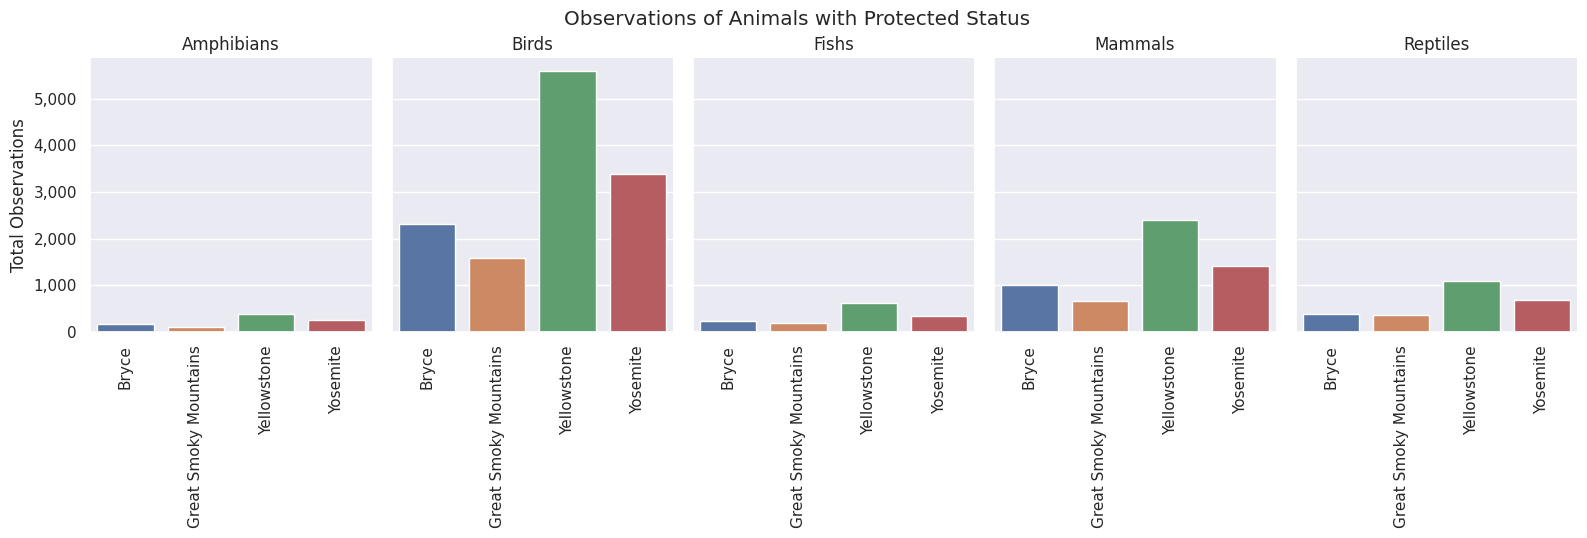

In [184]:
#For greater visibility into the protection status of relative groups of species and animals we can split into two dataframes, one for animals and one for animals.
#animals
biodiv_animals = biodiv[biodiv['category'].str.contains('Plant')==False].reset_index(drop=True)
biodiv_animals_gp_status= biodiv_animals.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()
category_order = list(biodiv_animals_gp_status.category.unique())
g=sns.catplot(
    data = biodiv_animals_gp_status[biodiv_animals_gp_status['protection_listing']==0],
    x='park_name',
    y='observations',
    col = 'category',
    #col_order = category_order,
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
)
h=sns.catplot(
    data = biodiv_animals_gp_status[biodiv_animals_gp_status['protection_listing']==1],
    x='park_name',
    y='observations',
    col = 'category',
    #col_order = category_order,
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = 0.8
)
g.set_axis_labels('', 'Total Observations')
g.set_xticklabels(rotation = 90)
g.set_titles("{col_name}")
g.figure.subplots_adjust(top=.86)
g.figure.suptitle('Observations of Animals of Least Concern')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
h.set_axis_labels('', 'Total Observations')
h.set_xticklabels(rotation = 90)
h.set_titles("{col_name}s")
h.figure.subplots_adjust(top=.86)
h.figure.suptitle('Observations of Animals with Protected Status')
for ax in h.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()
plt.close("all")

We can see from these graphs that across the board Yellowstone records the highest average observation counts across all conservation status, which stands to reason given their relative sizes.  
Yellowstone = 2,221,766 acres
Yosemite = 747,956 acres
Great Smoky Mountains = 533,427 acres
Bryce = 35,835 acres


In [185]:
#adding a column for park size
size_acres = {'Bryce': 35835, 'Great Smoky Mountains': 533427, 'Yosemite': 747956, 'Yellowstone':2221766}
biodiv['acres'] = biodiv['park_name'].apply(lambda x: size_acres.get(x))
print(biodiv.describe())
print('The average park size is '+str(biodiv.acres.mean())+' acres')
factor_acre= {}
for park, parksize in size_acres.items():
    print(str(park)+' has a size factor of x times the mean where x is: ')
    size_factor = round(parksize/(biodiv.acres.mean()),2)
    print(size_factor)
    factor_acre[park]=size_factor
biodiv['factor'] = biodiv['park_name'].apply(lambda x: factor_acre.get(x))
print(biodiv.describe())

       observations  protection_listing     acres
count       22164.0             22164.0   22164.0
mean          149.5                 0.0  884746.0
std            81.2                 0.2  814022.2
min             9.0                 0.0   35835.0
25%            88.0                 0.0  409029.0
50%           129.0                 0.0  640691.5
75%           217.0                 0.0 1116408.5
max           805.0                 1.0 2221766.0
The average park size is 884746.0 acres
Bryce has a size factor of x times the mean where x is: 
0.04
Great Smoky Mountains has a size factor of x times the mean where x is: 
0.6
Yosemite has a size factor of x times the mean where x is: 
0.85
Yellowstone has a size factor of x times the mean where x is: 
2.51
       observations  protection_listing     acres  factor
count       22164.0             22164.0   22164.0 22164.0
mean          149.5                 0.0  884746.0     1.0
std            81.2                 0.2  814022.2     0.9
min   

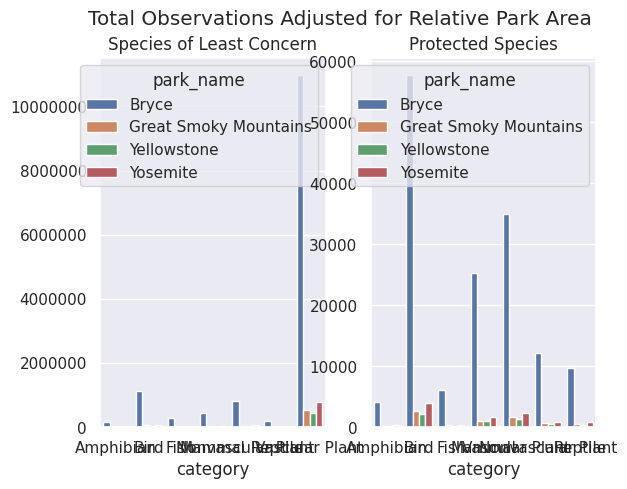

<Figure size 640x480 with 0 Axes>

In [203]:
biodiv_status_f = biodiv.drop(biodiv[biodiv['conservation_status']=='No Status'].index)
biodiv_stat_grouped_f = biodiv_status_f.groupby(['conservation_status', 'protection_listing', 'category', 'park_name', 'factor'], as_index=False)["observations"].sum()
fig, (ax1,ax2)=plt.subplots(1,2)
plt.subplot(1,2,1)
plt.ticklabel_format(style='plain', axis='y', scilimits=(99,99))
fig.suptitle('Total Observations Adjusted for Relative Park Area')
a= sns.barplot(x='category',
            y= (biodiv_stat_grouped_f['observations']/biodiv_stat_grouped_f['factor']),
            hue='park_name',
            data=biodiv_stat_grouped_f[biodiv_stat_grouped_f['protection_listing']==0],
            errorbar= None)
plt.title('Species of Least Concern')
plt.subplot(1,2,2)
plt.ticklabel_format(style='plain', axis='y', scilimits=(99,99))
b= sns.barplot(x='category',
            y= (biodiv_stat_grouped_f['observations']/biodiv_stat_grouped_f['factor']),
            hue='park_name',
            data=biodiv_stat_grouped_f[biodiv_stat_grouped_f['protection_listing']==1],
            errorbar= None)
plt.title('Protected Species')
plt.show()
plt.clf()

#### Analysis:

1) Is species category is correlated with it's conservation status?
2) Is National park correlated with observations counts or conservation status?
3) How are conservations status and observations correlated?

### Is species category correlated with conservation status?
- Method:
    - Group by species (scientific name) to meet independence of observation needed for Chi2
    - Split species into plant and animals for greater clarity.
    - Expected Contingency Tables for
    - Chi Squared
    - Cramér's V
- Analysis:
    - Discuss issue of 0's values in contingency table - to be a good candidate for Chi Squared analysis there should be fewer than 20% 0's in the table, though with a large dataset with strong tendencies we may find more. 
    - Plants show low Chi-squared with p-value of 0.8 -- Plants categories are likely not correlated with conservation status. ie, you're no more likely to see a Non-vascular than a Vascular plant with any particular conservation status. 
    - Animal categories vs conservation status show a high Chi-squared statistic (43.07), and low P-value (0.0003) indicating a statistically significant correlation between animal category and conservation status. 
    - Applying Cramér's V to the animal contingency and Chi2 shows a moderate, statistically significant, relationship across several variables, including Amphibian and Reptile and to a lesser degree, Fish. 
- Conclusion:
    There is some relationship between animal category and conservation status that is likely influenced by other variables. 

In [187]:
biodiv_species = biodiv.groupby(['scientific_name', 'category', 'conservation_status'], as_index=False)['observations'].sum()
status_category_contingency = pd.crosstab(biodiv_species['conservation_status'],biodiv_species['category'])
print(f"Contingency table for Conservation Status vs Category:\n{status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(status_category_contingency)
print(f"Chi-square Statistic - for plant and animal categories: {chi2}")
print(f"P-value - for plant and animal categories: {pval}")
print(f"Degrees of Freedom - for plant and animal categories: {dof}")

Contingency table for Conservation Status vs Category:
category             Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  Vascular Plant
conservation_status                                                                           
Endangered                   1     4     3       6                  0        0               1
In Recovery                  0     3     0       0                  0        0               0
Least Concern               72   413   114     146                328       73            4216
Species of Concern           4    68     4      22                  5        5              43
Threatened                   2     0     4       2                  0        0               2
Chi-square Statistic - for plant and animal categories: 591.1513416161314
P-value - for plant and animal categories: 1.6816257270187694e-109
Degrees of Freedom - for plant and animal categories: 24


In [188]:
#Calculate Cramér's V 
n = np.sum(status_category_contingency)
r,k = status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*min(k-1,r-1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: category
Amphibian           1.4
Bird                0.6
Fish                1.1
Mammal              0.9
Nonvascular Plant   0.7
Reptile             1.4
Vascular Plant      0.2
dtype: float64


In [189]:
biodiv_plant_species = biodiv_species[biodiv_species['category'].isin(['Nonvascular Plant', 'Vascular Plant'])]
biodiv_animal_species = biodiv_species[biodiv_species['category'].isin(['Bird', 'Amphibian', 'Reptile', 'Mammal', 'Fish'])]

In [190]:
plant_status_category_contingency = pd.crosstab(biodiv_plant_species['conservation_status'],biodiv_plant_species['category'])
print(f"Contingency table for Conservation Status vs Category - for Plants:\n{plant_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(plant_status_category_contingency)
print(f"Chi-square Statistic - for Plants: {chi2}")
print(f"P-value - for Plants: {pval}")
print(f"Degrees of Freedom - for Plants: {dof}")

Contingency table for Conservation Status vs Category - for Plants:
category             Nonvascular Plant  Vascular Plant
conservation_status                                   
Endangered                           0               1
Least Concern                      328            4216
Species of Concern                   5              43
Threatened                           0               2
Chi-square Statistic - for Plants: 0.9573945907675938
P-value - for Plants: 0.8115596253037896
Degrees of Freedom - for Plants: 3


In [191]:
animal_status_category_contingency = pd.crosstab(biodiv_animal_species['conservation_status'],biodiv_animal_species['category'])
print(f"Contingency table for Conservation Status vs Category - for animals:\n{animal_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(animal_status_category_contingency)
print(f"Chi-square Statistic - for animals: {chi2}")
print(f"P-value - for animals: {pval}")
print(f"Degrees of Freedom - for animals: {dof}")

Contingency table for Conservation Status vs Category - for animals:
category             Amphibian  Bird  Fish  Mammal  Reptile
conservation_status                                        
Endangered                   1     4     3       6        0
In Recovery                  0     3     0       0        0
Least Concern               72   413   114     146       73
Species of Concern           4    68     4      22        5
Threatened                   2     0     4       2        0
Chi-square Statistic - for animals: 43.0693765443132
P-value - for animals: 0.00027280616529364596
Degrees of Freedom - for animals: 16


In [192]:
#Calculate Cramér's V 
n = np.sum(animal_status_category_contingency)
r,k = animal_status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*min(k-1,r-1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: category
Amphibian   0.4
Bird        0.1
Fish        0.3
Mammal      0.2
Reptile     0.4
dtype: float64


Is National park correlated with observations counts?
- Method:
    - Assess Central Tendency
    - ANOVA
    - Tukey HSD
    
- Analysis:
- Conclusion:

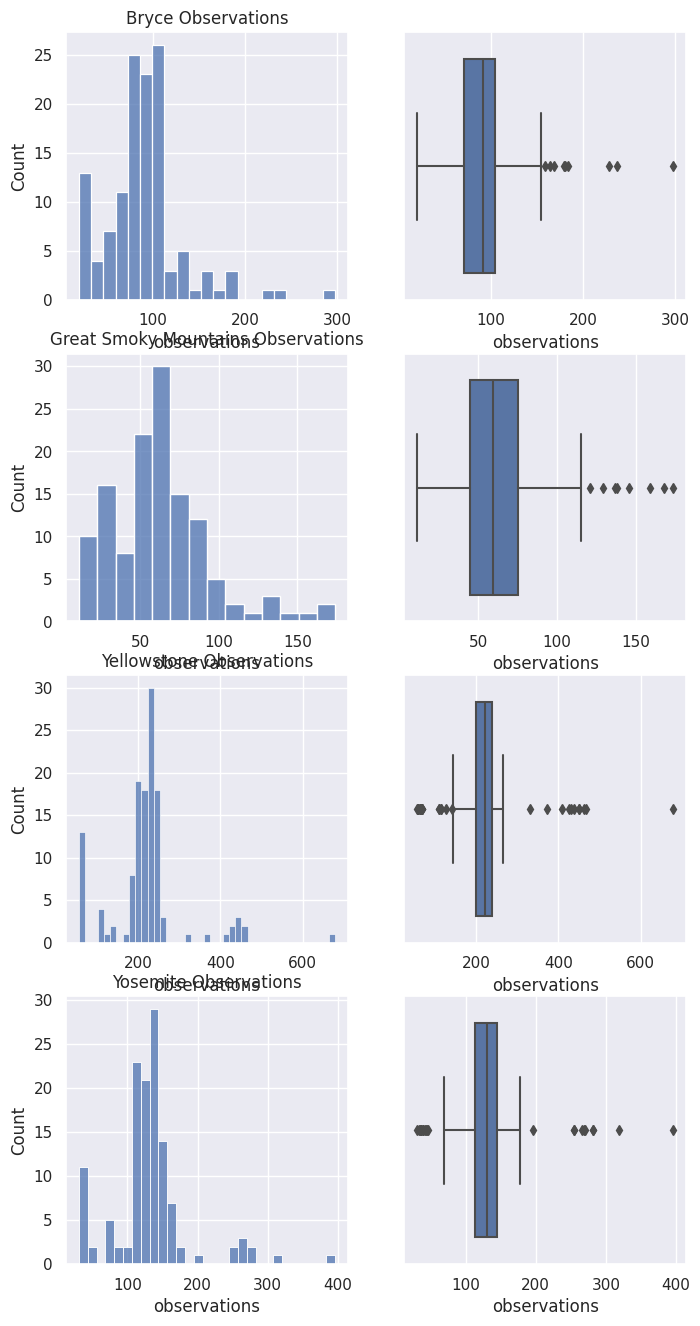

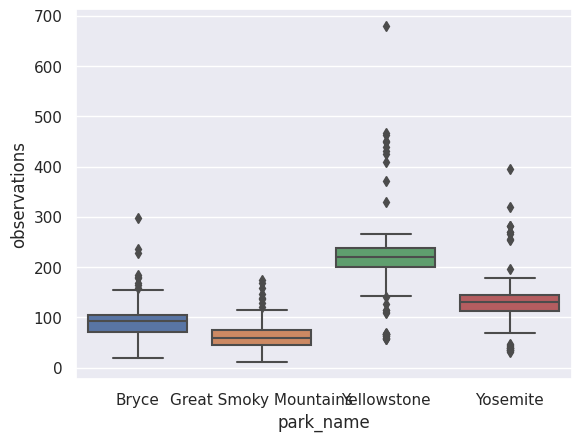

       Bryce  Great Smoky Mountains  Yellowstone  Yosemite
count  128.0                  128.0        128.0     128.0
mean    90.5                   62.1        219.9     131.8
std     42.6                   31.5         91.4      56.4
min     20.0                   11.0         57.0      31.0
25%     70.5                   44.5        199.8     113.5
50%     92.0                   59.5        221.0     131.0
75%    104.2                   75.0        238.5     145.2
max    298.0                  174.0        679.0     396.0


In [193]:
biodiv_conservation_animals = biodiv_animals[biodiv_animals['protection_listing']==1]
parks = list(biodiv['park_name'].unique())
num = 1
plt.figure(figsize=(8,16))
park_describe = {}
for park in parks:
    park_biodiv = biodiv_conservation_animals[biodiv_conservation_animals['park_name']==park]
    park_mean = park_biodiv['observations'].describe(include=all)
    park_describe[park]= park_mean
    plt.subplot(4,2,num)
    sns.histplot(park_biodiv['observations'])
    plt.title(park + ' Observations')
    num +=1
    plt.subplot(4,2,num)
    sns.boxplot(x='observations', data=park_biodiv)
    num +=1
plt.show()
plt.close('all')
sns.boxplot(data=biodiv_conservation_animals, x='park_name', y='observations')
plt.show()
plt.close('all')
parks_describe_df = pd.DataFrame(park_describe)
print(parks_describe_df)

ANOVA F and p value: 
              sum_sq    df     F  PR(>F)
park_name 1817091.9   3.0 169.0     0.0
Residual  1820856.6 508.0   NaN     NaN
Model Results Summary: 
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     169.0
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           5.73e-76
Time:                        16:20:33   Log-Likelihood:                -2819.7
No. Observations:                 512   AIC:                             5647.
Df Residuals:                     508   BIC:                             5664.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         co

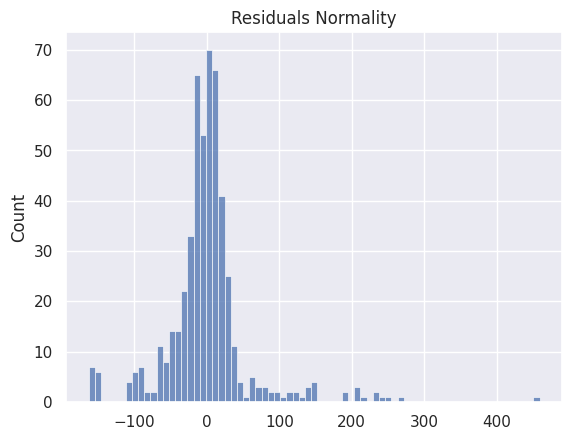

<Figure size 640x480 with 0 Axes>

In [194]:
#ANOVA using OLS- Ordinary Least Squares
model = sm.OLS.from_formula('observations~park_name', biodiv_conservation_animals)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)
print(f"ANOVA F and p value: \n {anova_table}")
print(f"Model Results Summary: \n{results.summary()}")
residuals = biodiv_conservation_animals.observations-results.predict(biodiv_conservation_animals)
plt.figure()
sns.histplot(residuals)
plt.title("Residuals Normality")
plt.show()
plt.clf()


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
                Bryce Great Smoky Mountains -28.3203 0.001  -47.6099  -9.0307   True
                Bryce           Yellowstone 129.4609   0.0  110.1713 148.7506   True
                Bryce              Yosemite  41.3438   0.0   22.0541  60.6334   True
Great Smoky Mountains           Yellowstone 157.7812   0.0  138.4916 177.0709   True
Great Smoky Mountains              Yosemite  69.6641   0.0   50.3744  88.9537   True
          Yellowstone              Yosemite -88.1172   0.0 -107.4068 -68.8276   True
------------------------------------------------------------------------------------


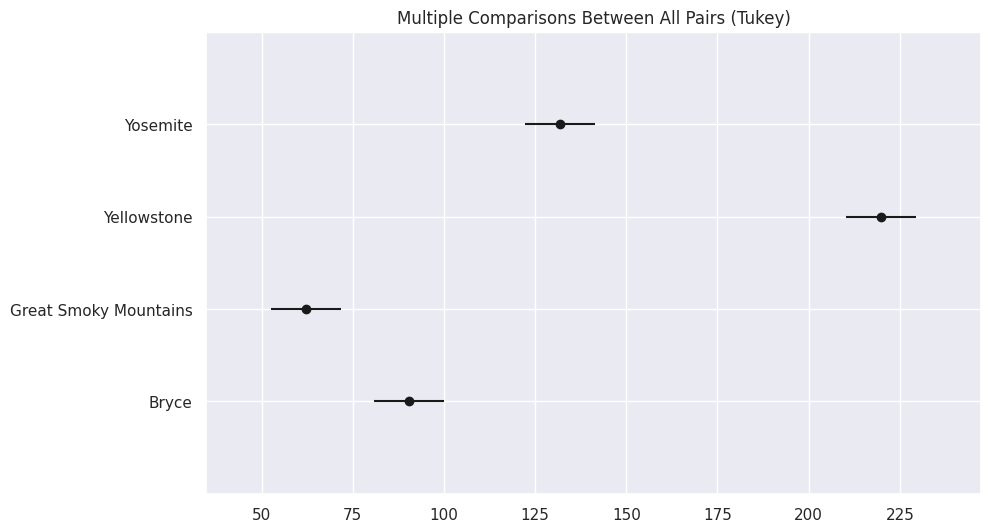

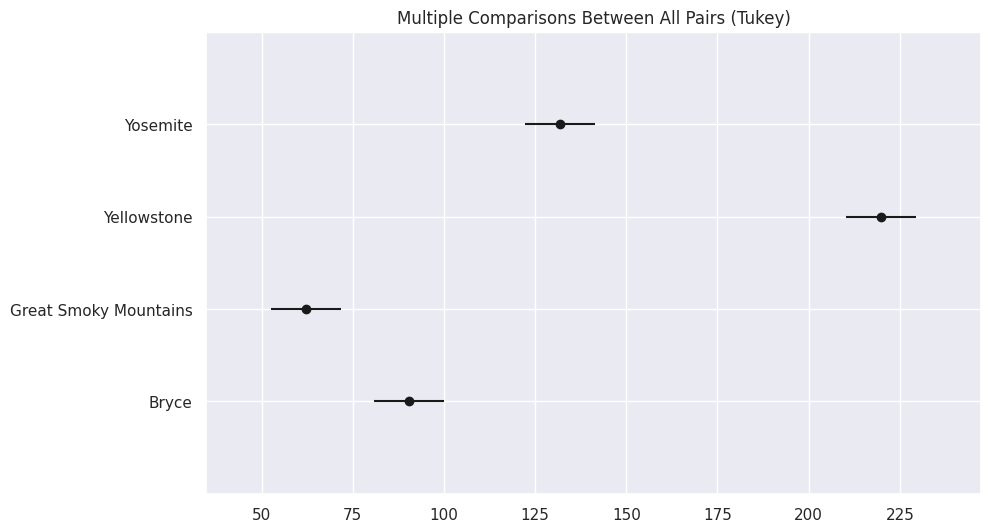

In [195]:
tukey_results = pairwise_tukeyhsd(endog=biodiv_conservation_animals['observations'], groups=biodiv_conservation_animals['park_name'], alpha=0.05)

# Print the results
print(tukey_results)
tukey_results.plot_simultaneous()

Since there is a correlation between conservation status and category and between park and observations. Let's see if there is an interaction between park and category with respect to their impact on observations.
- Method:
    1) 2-Way Anova
- Analysis:
- Conclusion: Park and Category are both independently correlated to observations in this data set, but they do not interact. 

In [196]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
model2 = sm.OLS.from_formula('observations~C(park_name)*C(category)', biodiv_conservation_animals)
results2 = model2.fit()
anova_table_2way = sm.stats.anova_lm(results2, typ=2)

print(anova_table_2way)

                                  sum_sq          df           F    PR(>F)
C(park_name)             1817091.9453125   3.0000000 173.1951432 0.0000000
C(category)                78915.6423715   4.0000000   5.6413516 0.0001908
C(park_name):C(category)   21320.6687351  12.0000000   0.5080420 0.9098909
Residual                 1720620.2982684 492.0000000         NaN       NaN


How are conservations status and observations correlated?
- Method:
- Analysis:
- Conclusion:

  conservation_status  observations
0          Endangered    47.0714286
1         In Recovery   116.0000000
2  Species of Concern   140.1432039
3          Threatened    87.0937500


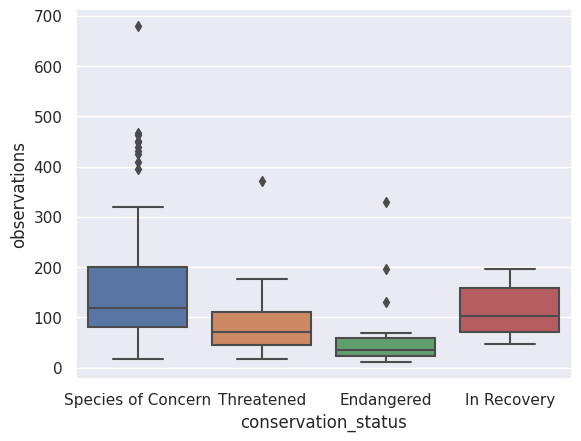

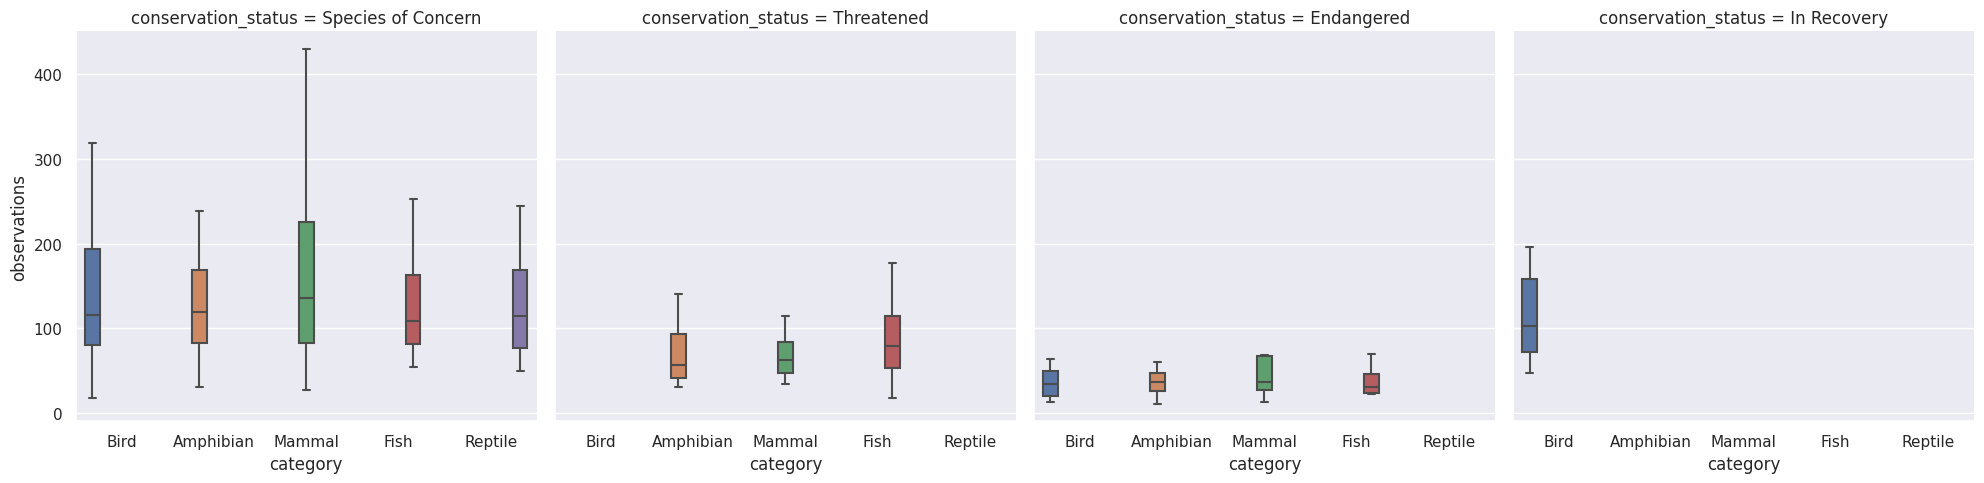

In [197]:
observation_mean_status = biodiv_conservation_animals.groupby('conservation_status',as_index=False)['observations'].mean()
print(observation_mean_status)
sns.boxplot(x='conservation_status', y='observations', data= biodiv_conservation_animals)
sns.catplot(data=biodiv_conservation_animals, col = 'conservation_status', x='category', y='observations', kind ='box', hue = 'category', showfliers = False)

#### Conclusion:
- Reprise questions and conclusions with a few key insights/applications.
    - Category is statisticall correlated with conservation status to a small to moderate degree
    - Park is strongly correlated with observations for animal species with a conservation protection status.
    - These are independent correlations, they do not interact. 
- Raise any new questions or future work
    - Interesting to investigate a more complete data set that include datetime and location of observations.
    - Interesting to investigate observations over time. 

#### Appendix:
- Technical Descriptions of unusual stats
- Detailed Tables, Computer output (not necessarily human friendly)
- Interesting or excessive figures
- Computer code used to obtain results. 